# Import thư viện

In [1]:
import numpy as np
from keras.models import Sequential
import keras
from keras.layers import ConvLSTM2D, Bidirectional
import os
import cv2
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_addons as tfa
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools, algorithms
from tensorflow.keras.models import load_model

c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you 

# Dữ liệu đầu vào

### Đọc dữ liệu ảnh

In [2]:
# Đường dẫn đến thư mục chứa ảnh
image_folder = r"C:\Users\Administrator\Desktop\Fair_2024_BacSon_ConvLSTM_Bi-ConvLSTM_ConvGRU-main\data"

# Đọc từng file ảnh
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

In [3]:
# Chuyển ảnh về ma trận ảnh Gray

def matrix_images(image_folder, image_files):
    matrix_img = []
    for img_file in image_files:
        img_path = os.path.join(image_folder, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        matrix_img.append(image)

    return matrix_img

data = matrix_images(image_folder, image_files)

### Chuẩn hóa dữ liệu

In [4]:
# Áp dụng Min-Max Scaling chuẩn hóa dữ liệu
def min_max_scaling(data):
    # Chuyển danh sách các mảng numpy thành một mảng numpy đa chiều
    data_array = np.array(data)

    # Tính giá trị min và max trên toàn bộ dữ liệu
    data_min = np.min(data_array)
    data_max = np.max(data_array)

    # Áp dụng công thức Min-Max Scaling
    scaled_data = (data_array - data_min) / (data_max - data_min)

    return scaled_data

### Tạo nhãn cho dữ liệu

In [5]:
data = min_max_scaling(data)
data = np.expand_dims(data, axis=-1)

In [6]:
def create_image_sequences(data, time_steps):
    num_samples, height, width, channels = data.shape
    num_frames = num_samples - time_steps
    input_sequences = np.zeros((num_frames, time_steps, height, width, channels))
    labels = np.zeros((num_frames, height, width, channels))  # Khởi tạo mảng label

    for i in range(num_frames):
        input_sequences[i] = data[i:i+time_steps]
        labels[i] = data[i+time_steps]  # Xác định label là frame tiếp theo

    return input_sequences, labels

# Tạo chuỗi dữ liệu với 4 ảnh liên tiếp từ dữ liệu hình ảnh
X_data, y_data = create_image_sequences(data, 4)

### Chia dữ liệu

In [7]:
# Chia dữ liệu
size = int(len(X_data) * 0.8)
size_val = int((len(X_data) - size) / 2)

X_train = X_data[:size]
X_val = X_data[size:size + size_val]
X_test = X_data[-size_val:]

y_train = y_data[:size]
y_val = y_data[size:size + size_val]
y_test = y_data[- size_val:]

In [8]:
# Kiểm tra kích thước của X_train
print("Kích thước của X_train:", X_train.shape)
print("Kích thước của X_val:", X_val.shape)
print("Kích thước của X_test:", X_test.shape)

print("Kích thước của y_train:", y_train.shape)
print("Kích thước của y_val:", y_val.shape)
print("Kích thước của y_test:", y_test.shape)

Kích thước của X_train: (48, 4, 150, 150, 1)
Kích thước của X_val: (6, 4, 150, 150, 1)
Kích thước của X_test: (6, 4, 150, 150, 1)
Kích thước của y_train: (48, 150, 150, 1)
Kích thước của y_val: (6, 150, 150, 1)
Kích thước của y_test: (6, 150, 150, 1)


# Mô hình ConvLSTM + GA

In [9]:
def conv_BiLSTM(input_lstm, filters1, filters2, kernel_size1, kernel_size2, kernel_size3, activation):
    # Xây dựng mô hình ConvLSTM
    inputs_shape = input_lstm
    model_lstm = Sequential()
    model_lstm.add(Bidirectional(ConvLSTM2D(filters=filters1, kernel_size=kernel_size1, input_shape=inputs_shape, 
                                            padding='same', activation=activation, return_sequences=True)))
    model_lstm.add(Bidirectional(ConvLSTM2D(filters=filters2, kernel_size=kernel_size2, padding='same', 
                                            activation=activation, return_sequences=True)))
    model_lstm.add(Bidirectional(ConvLSTM2D(filters=1, kernel_size=kernel_size3, padding='same', activation='tanh')))

    return model_lstm

In [10]:
def fitness_function(X_train, y_train, X_val, y_val, filters1, filters2, kernel_size1, kernel_size2, kernel_size3, 
                     activation, optimizer, epochs=1, model_path=""):
    # Xây dựng mô hình ConvLSTM
    time_step, height, width, channels = X_train.shape[1:]
    input_lstm = (time_step, height, width, channels)
    model_lstm = conv_BiLSTM(input_lstm, filters1, filters2, kernel_size1, kernel_size2, kernel_size3, activation)
    
    # Compile mô hình
    model_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

    # Dừng sớm
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    
    callbacks = [early_stopping]
    if model_path:
        model_checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
        callbacks.append(model_checkpoint)

    # Training model
    history = model_lstm.fit(X_train, y_train,
                             batch_size=4,
                             epochs=epochs, 
                             validation_data=(X_val, y_val),
                             callbacks=callbacks)
    # Hàm mục tiêu
    val_loss = np.min(history.history['val_loss'])

    if model_path:
        # Load the best model
        best_model = load_model(model_path)
    else:
        best_model = model_lstm

    return val_loss, best_model, history

In [11]:
# Hàm đánh giá cá thể trong quần thể
def evaluate(individual):
    if len(individual) < 4:  # Kiểm tra xem cá thể có đủ độ dài không
        return float('inf'),  # Trả về một giá trị fitness vô cực để loại bỏ cá thể này

    filters1, filters2, kernel_size1, kernel_size2, kernel_size3, activation = individual
    epochs = 50

    print("Train Adam")
    optimizer_Adam = keras.optimizers.Adam(learning_rate=1e-3)
    val_loss_adam, _, _ = fitness_function(X_train, y_train, X_val, y_val, filters1, filters2, 
                                             kernel_size1, kernel_size2, kernel_size3, activation, optimizer_Adam, epochs=epochs)
    return val_loss_adam,

    # print("Train YoGi")
    # optimizer_Yogi = tfa.optimizers.Yogi(learning_rate=1e-3)
    # val_loss_yogi, _, _ = fitness_function(X_train, y_train, X_val, y_val, filters1, filters2, 
    #                                          kernel_size1, kernel_size2, kernel_size3, activation, optimizer_Yogi, epochs=epochs)

    # if val_loss_adam < val_loss_yogi:
    #     return val_loss_adam,
    # else:
    #     return val_loss_yogi,

In [12]:
# Định nghĩa hàm tạo quần thể
def create_population(n, filters_func1, filters_func2, kernel_size_func1, kernel_size_func2, kernel_size_func3, activation_func):
    population = [creator.Individual([filters_func1(), filters_func2(), kernel_size_func1(), 
                                      kernel_size_func2(), kernel_size_func3(), activation_func()]) for _ in range(n)]
    return population

In [13]:
# Số lượng quần thể ban đầu
num_populations = 4
# Số lượng cá thể trong quần thể ban đầu
individuals = 5
# Quá trình lai ghép và đột biến
num_generations = 2

epochs = 200

In [ ]:
# Khởi tạo hàm mục tiêu
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Khởi tạo toolbox
toolbox = base.Toolbox()
toolbox.register("attr_filters", random.choice, [16, 32, 64, 128])
toolbox.register("attr_kernel_size", random.choice, [(3, 3), (5, 5), (7, 7)])
toolbox.register("attr_activation", random.choice, ["tanh", "relu", "sigmoid"])

# Đăng ký cá thể và quần thể
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_filters, toolbox.attr_filters, 
                  toolbox.attr_kernel_size, toolbox.attr_kernel_size, 
                  toolbox.attr_kernel_size, toolbox.attr_activation), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Đăng ký các toán tử lai ghép, đột biến và chọn lọc
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, 
                 low=[16, 16, (3, 3), (3, 3), (3, 3), 0], 
                 up=[128, 128, (7, 7), (7, 7), (7, 7), 2], indpb=0.15)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Tạo và in quần thể ban đầu
populations = []
for i in range(num_populations):
    population = create_population(individuals, toolbox.attr_filters, toolbox.attr_filters, 
                                   toolbox.attr_kernel_size, toolbox.attr_kernel_size, toolbox.attr_kernel_size, 
                                   toolbox.attr_activation)
    populations.append(population)
    print(f"Quần thể ban đầu {i + 1}:")
    for j, ind in enumerate(population):
        print(f"Cá thể thứ {j}: {ind}")
    print()

# Đánh giá fitness và chọn lọc cá thể tốt nhất cho mỗi quần thể ban đầu
best_individuals = []
for population in populations:
    fits = toolbox.map(toolbox.evaluate, population)
    for fit, ind in zip(fits, population):
        ind.fitness.values = fit
    best_ind = min(population, key=lambda ind: ind.fitness.values)
    best_individuals.append(best_ind)
    print(f"Cá thể tốt nhất trong quần thể thứ {populations.index(population) + 1}: {best_ind} ban đầu")
print()

print("Bắt đầu quá trình lai ghép và đột biến...")
print()

# Quá trình lai ghép và đột biến
for gen in range(num_generations):
    # Tạo quần thể con bằng cách lai ghép và đột biến từ các cá thể tốt nhất
    offspring = algorithms.varAnd(best_individuals, toolbox, cxpb=0.7, mutpb=0.15)
    # offspring = algorithms.varAnd(best_individuals, toolbox, mutpb=0.15)
    print(f"Quần thể con F{gen + 1} đã được tiến hóa:")
    for i, ind in enumerate(offspring):
        print(f"Cá thể thứ {i}: {ind}")

    # Đánh giá fitness của quần thể con
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    best_ind = min(offspring, key=lambda ind: ind.fitness.values)
    best_individuals.append(best_ind)
    print(f"Cá thể tốt nhất trong quần thể con F{gen + 1}: {best_ind}")

    # Chọn lọc cá thể để tạo quần thể mới cho thế hệ tiếp theo
    best_individuals = toolbox.select(offspring, k=len(best_individuals))
    print()

# In ra cá thể tốt nhất cuối cùng
best_ind = min(best_individuals, key=lambda ind: ind.fitness.values)
print("Cá thể tốt nhất cuối cùng:")
print(best_ind)

# Đánh giá và Test mô hình

### Các tham số từ cá thể tốt nhất

In [25]:
def plot_loss_model(history):
    # Kiểm tra loại của history để trích xuất giá trị loss phù hợp
    if isinstance(history, dict):
        train_loss = history['loss']
        val_loss = history['val_loss']
    else:
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

    # Vẽ biểu đồ
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, linestyle='-', label='Train loss')
    plt.plot(val_loss, linestyle='-', label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train loss và Val loss của mô hình')
    plt.yscale('log')  # Scale y-axis to logarithmic scale
    plt.legend()  # Thêm nhãn chú thích
    plt.show()

In [15]:
# Các tham số đầu vào mô hình LSTM
best_ind = [64, 128, (3, 3), (7, 7), (7, 7), 'relu']
filters1, filters2, kernel_size1, kernel_size2, kernel_size3, activation = best_ind
print(filters1, filters2, kernel_size1, kernel_size2, kernel_size3, activation)

64 128 (3, 3) (7, 7) (7, 7) relu


In [16]:
optimizer_Adam = keras.optimizers.Adam(learning_rate=1e-3)
model_path_Adam = './Ketqua_GA/BiConvLSTM/BiConvLSTM_Adam.hdf5'
_, model_lstm_Adam, history_lstm_Adam = fitness_function(X_train, y_train, X_val, y_val, filters1, filters2, 
                                                           kernel_size1, kernel_size2, kernel_size3, 
                                                           activation, optimizer_Adam, epochs=epochs, model_path=model_path_Adam)


Epoch 1/200

12/12 [==============================] - ETA: 0s - loss: 0.0200 
Epoch 1: val_loss improved from inf to 0.01327, saving model to ./Ketqua_GA/BiConvLSTM\BiConvLSTM_Adam.hdf5
12/12 [==============================] - 701s 57s/step - loss: 0.0200 - val_loss: 0.0133
Epoch 2/200


c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - ETA: 0s - loss: 0.0115 
Epoch 2: val_loss improved from 0.01327 to 0.01172, saving model to ./Ketqua_GA/BiConvLSTM\BiConvLSTM_Adam.hdf5
12/12 [==============================] - 673s 56s/step - loss: 0.0115 - val_loss: 0.0117
Epoch 3/200
12/12 [==============================] - ETA: 0s - loss: 0.0105 
Epoch 3: val_loss improved from 0.01172 to 0.01081, saving model to ./Ketqua_GA/BiConvLSTM\BiConvLSTM_Adam.hdf5
12/12 [==============================] - 664s 55s/step - loss: 0.0105 - val_loss: 0.0108
Epoch 4/200
12/12 [==============================] - ETA: 0s - loss: 0.0097 
Epoch 4: val_loss improved from 0.01081 to 0.01002, saving model to ./Ketqua_GA/BiConvLSTM\BiConvLSTM_Adam.hdf5
12/12 [==============================] - 662s 55s/step - loss: 0.0097 - val_loss: 0.0100
Epoch 5/200
12/12 [==============================] - ETA: 0s - loss: 0.0089 
Epoch 5: val_loss improved from 0.01002 to 0.00915, saving model to ./Ketqua_GA/BiConvLSTM\BiConvLSTM

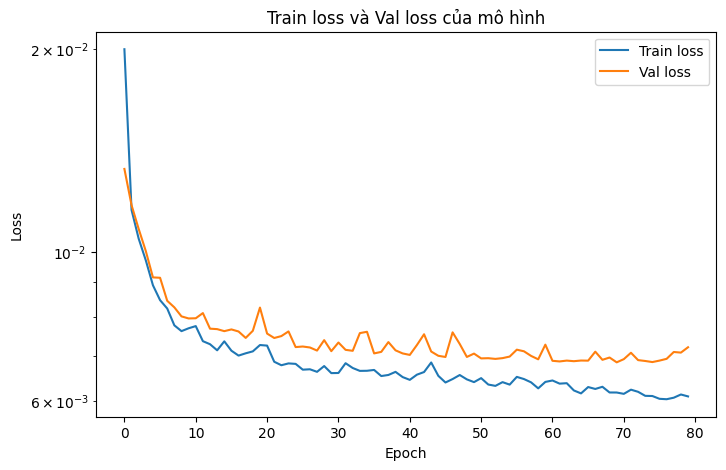

In [26]:
plot_loss_model(history_lstm_Adam)

In [18]:
optimizer_Yogi = tfa.optimizers.Yogi(learning_rate=1e-3)
model_path_Yogi = './Ketqua_GA/BiConvLSTM/BiConvLSTM_Yogi.hdf5'
_, model_lstm_Yogi, history_lstm_Yogi = fitness_function(X_train, y_train, X_val, y_val, filters1, filters2, 
                                                           kernel_size1, kernel_size2, kernel_size3, activation, 
                                                           optimizer_Yogi, epochs=epochs, model_path=model_path_Yogi)

Epoch 1/200
12/12 [==============================] - ETA: 0s - loss: 0.0464 
Epoch 1: val_loss improved from inf to 0.04062, saving model to ./Ketqua_GA/BiConvLSTM\BiConvLSTM_Yogi.hdf5
12/12 [==============================] - 669s 55s/step - loss: 0.0464 - val_loss: 0.0406
Epoch 2/200
12/12 [==============================] - ETA: 0s - loss: 0.0444 
Epoch 2: val_loss improved from 0.04062 to 0.03855, saving model to ./Ketqua_GA/BiConvLSTM\BiConvLSTM_Yogi.hdf5
12/12 [==============================] - 661s 55s/step - loss: 0.0444 - val_loss: 0.0386
Epoch 3/200
12/12 [==============================] - ETA: 0s - loss: 0.0420 
Epoch 3: val_loss improved from 0.03855 to 0.03605, saving model to ./Ketqua_GA/BiConvLSTM\BiConvLSTM_Yogi.hdf5
12/12 [==============================] - 666s 56s/step - loss: 0.0420 - val_loss: 0.0361
Epoch 4/200
12/12 [==============================] - ETA: 0s - loss: 0.0388 
Epoch 4: val_loss improved from 0.03605 to 0.03265, saving model to ./Ketqua_GA/BiConvLSTM\Bi

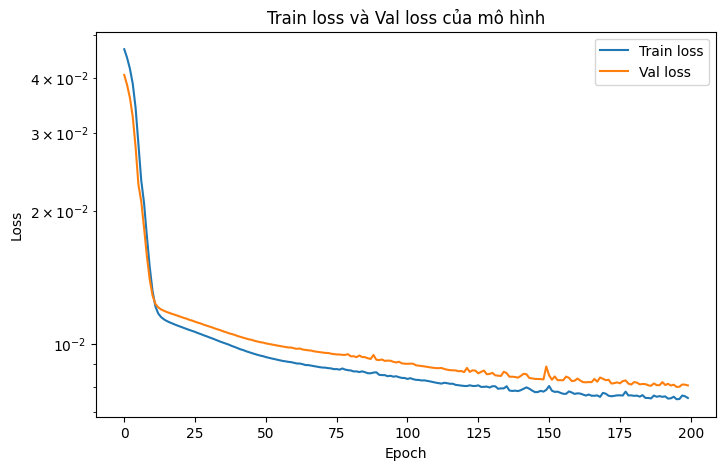

In [27]:
plot_loss_model(history_lstm_Yogi)

### Đánh giá mô hình

In [20]:
# Đánh giá mô hình trên tập test
loss1 = model_lstm_Adam.evaluate(X_val, np.array(y_val))
print(f'Val loss Adam: {loss1}')

loss2 = model_lstm_Yogi.evaluate(X_val, np.array(y_val))
print(f'Val loss Yogi: {loss2}')

if loss1 < loss2:
    print("Best Model Adam")
    model = model_lstm_Adam
else:
    print("Best Model YoGi")
    model = model_lstm_Yogi

1/1 [==============================] - 18s 18s/step - loss: 0.0068
Val loss Adam: 0.006844217423349619
1/1 [==============================] - 20s 20s/step - loss: 0.0080
Val loss Yogi: 0.00799021776765585
Best Model Adam


### Dự đoán 

1/1 [==============================] - 19s 19s/step
Mean Squared Error (MSE): 0.007641355785333971
Mean Absolute Error (MAE): 0.04289921022817158
R-squared (R2) Score: 0.7436291414410907


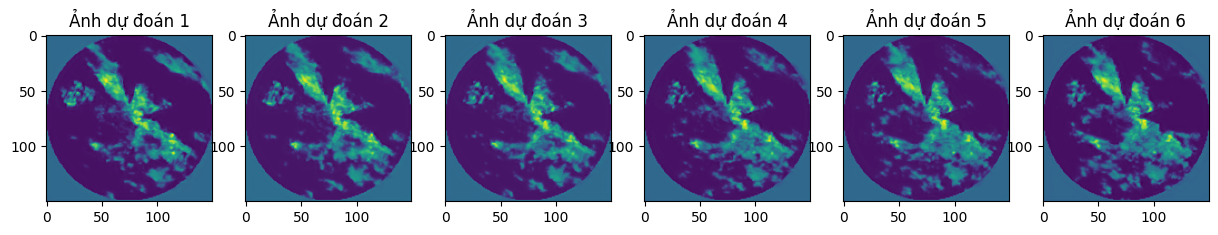

In [21]:
def test_model_BiConvLSTM(model, X_test, y_test):
    # Dự đoán ảnh mới
    predicted = model.predict(X_test)
    predicted_images = np.mean(predicted, axis=-1, keepdims=True)  # Tính trung bình hai kênh màu
    y_test = np.array(y_test)

    # Đánh giá MSE MAE R^2
    mse = mean_squared_error(y_test.flatten(), predicted_images.flatten())
    print("Mean Squared Error (MSE):", mse)
    mae = mean_absolute_error(y_test.flatten(), predicted_images.flatten())
    print("Mean Absolute Error (MAE):", mae)
    r2 = r2_score(y_test.flatten(), predicted_images.flatten())
    print("R-squared (R2) Score:", r2)

    # Hiển thị các ảnh dự đoán
    fig, axs = plt.subplots(1, len(predicted_images), figsize=(15, 25))
    for i in range(len(predicted_images)):
        axs[i].imshow(predicted_images[i, :, :, 0])  # Hiển thị ảnh cuối cùng trong mỗi mẫu dự đoán
        axs[i].set_title(f"Ảnh dự đoán {i+1}")
    plt.show()

test_model_BiConvLSTM(model, X_test, y_test)